In [7]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, det
import yfinance as yf

In [5]:
# ! pip install yfinance

Выберем четыре тикера так, чтобы два из них содержали котировки
акций технологических компаний (AMZN, NVDA), а других два — котировки
биржевых инвестиционных фондов (ITB, SPY). Период – ежедневные котировки
акции в течении года от 01.01.2021 до 01.01.2022.

1. Amazon (тикер: AMZN) - американский оnline портал по продаже товаров и услуг.

2. Корпорация NVIDIA (тикер: NVDA) специализируется на графике для персональных компьютеров (ПК), графических процессорах (GPU), а также на искусственном интеллекте (AI).

3. iShares U.S. Home Construction ETF (тикер NYSE: ITB) — фонд, предоставляющий доступ к американской индустрии жилищного строительства и недвижимости.

4. SPDR S&P 500 ETF Trust (тикер NYSE: SPY) — исторически первый успешный американский фонд, акции которого обращаются на Нью-Йоркской бирже. 

In [27]:
# получим данные: 
a = yf.download('AMZN','2021-01-01','2022-01-01')["Close"].values
b = yf.download('NVDA','2021-01-01','2022-01-01')["Close"].values
c = yf.download('ITB','2021-01-01','2022-01-01')["Close"].values
d = yf.download('SPY','2021-01-01','2022-01-01')["Close"].values

# преобразуем в один массив: 
data = np.array([a,b,c,d])

# и создадим таблицу значений доходности по дням в течение года: 
df = pd.DataFrame(data.T).apply(lambda x: ((x.shift(-1)-x)/x)[:-1].values)
df.columns = ['AMZN', 'NVDA', 'ITB', 'SPY']

V = df.cov() * 10_000    # ковариационная матрица
mu = df.mean(axis=0)    # вектор доходностей

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [55]:
print('ковариационная матрица:\n', V)

ковариационная матрица:
           AMZN      NVDA       ITB       SPY
AMZN  2.293585  2.386155  0.679699  0.690560
NVDA  2.386155  8.061867  1.562878  1.360397
ITB   0.679699  1.562878  2.643368  0.866054
SPY   0.690560  1.360397  0.866054  0.675738


In [56]:
print('вектор доходностей: \n', mu)

вектор доходностей: 
 AMZN    0.000295
NVDA    0.003621
ITB     0.001782
SPY     0.001042
dtype: float64


# 1. Портфель минимального риска

In [39]:
I = np.array([1,1,1,1])
V_inv = inv(V)

alpha = I.T @ inv(V) @ I
beta = mu.T @ inv(V) @ mu
gamma = mu.T @ inv(V) @ mu
delta = alpha*gamma - beta**2

In [41]:
X = 1/alpha * (inv(V) @ I)
X, print(df.columns)

Index(['AMZN', 'NVDA', 'ITB', 'SPY'], dtype='object')


(array([ 0.0545992 , -0.12273818, -0.11205978,  1.18019875]), None)

Видим отрицательные доли NVDA, ITB - их следует исключить из портфеля и продать. 

In [53]:
mu_X = X @ mu
print('доходность: ', round(mu_X * 100, 4))

sigma_X = 1/alpha**0.5
print('риск:', round(sigma_X,4))

доходность:  0.0602
риск: 0.7558


# 2. Портфель минимального риска с фиксированным уровнем доходности 

Допустим, инвестор хотел бы получать от акций больше, чем принятая ЦБ учетная ставка в 7,5% 

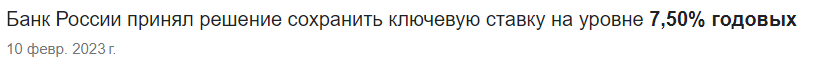

In [80]:
E = 7.5    # уровень доходности

lmda = (gamma - beta * E) / delta
delt_mu = (alpha * E - beta) / delta
X = inv(V) @ (lmda*I + delt_mu*mu)
X, print(df.columns)

Index(['AMZN', 'NVDA', 'ITB', 'SPY'], dtype='object')


(array([-1851.76920463,  1101.5970243 ,   628.16894222,  2815.21272502]), None)

Следует продать акции AMZN, т.к. доля отрицательная 

In [81]:
mu_X = X @ mu
print('доходность: ', round(mu_X,4) )   # проверка заданного уровня доходности 

# найдем риск по уравнению минимальной границы: 
sigma_X = (alpha*(E**2)/delta - 2*beta*E/delta + gamma/delta)**0.5
print('риск:', round(sigma_X,4))


доходность:  7.4961
риск: 4383.4014


# 3. Портфель максимальной полезности

Для двух активов в Excel я рассчитывала через U' = 0, однако с большим числом активов удобнее проводить расчеты по указанной в методичке формуле.

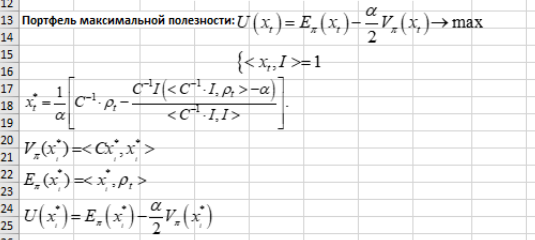

In [90]:
a = 0.3     # степень непринятия риска инвестором 

X = 1/a * (inv(V) @ mu - inv(V) @ I*((inv(V) @ I @ mu)- a)/ (inv(V) @ I @ I))

print('портфель максимальной полезности: ')
X, print(df.columns)

портфель максимальной полезности: 
Index(['AMZN', 'NVDA', 'ITB', 'SPY'], dtype='object')


(array([ 0.0519985 , -0.12087477, -0.11084978,  1.17972605]), None)

In [99]:
print("Риск портфеля", round((X.T @ V @ X)**0.5, 4))
print('доходность: ', round(X @ mu,4))
print('полезность U: ', round(X @ mu - a/2 * X.T @ V @ X, 4))

Риск портфеля 0.7558
доходность:  0.0006
полезность U:  -0.0851
